In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
temp_data_train = pd.read_csv('../Data/train_data.csv')
temp_data_test = pd.read_csv('../Data/test_data.csv')
# Convert the 'date' column to datetime
temp_data_train['date'] = pd.to_datetime(temp_data_train['date'])
temp_data_test['date'] = pd.to_datetime(temp_data_test['date'])

T_actual_train = temp_data_train['mean'].to_numpy()
T_actual_test = temp_data_test['mean'].to_numpy()

In [3]:
print(T_actual_train.shape)
print(T_actual_test.shape)

(33286,)
(365,)


Mean Absolute Error (MAE): 3.5889939864050735
Mean Squared Error (MSE): 19.61203766006271
Root Mean Squared Error (RMSE): 4.428548030682597
Correlation Coefficient: 0.8176080237968663


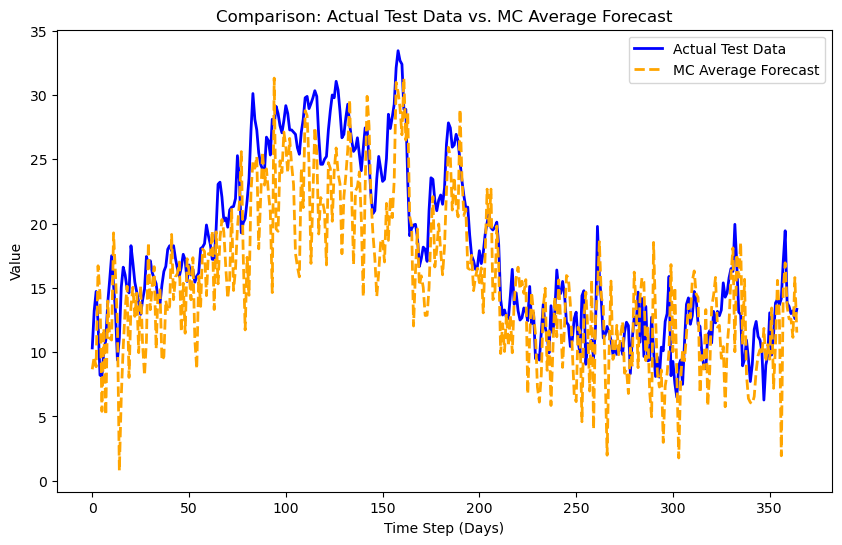

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Load your parameters (shape assumed to be (N,))
S = np.load("S_seasonal.npy")          # Seasonal component
k = -0.1571                           # Fixed speed of mean reversion (a scalar)
sigma = np.load("sigma_timevarying.npy")  # Time-varying volatility

# Set forecast parameters
forecast_end = 365  # number of forecast time steps
n_paths = 1000      # number of Monte Carlo simulation paths

# Initialize forecasts: start with the last actual observation from training data.
T_all = np.zeros((n_paths, forecast_end))
T_all[:, 0] = T_actual_train[-1]

# Rolling forecast using actual data when available
for t in range(1, forecast_end):
    eps = np.random.randn(n_paths)  # random shock for each simulation path
    
    # Use the actual observed data at t-1 if available, otherwise fall back on the simulation
    if t-1 < len(T_actual_test):
        previous_value = T_actual_test[t-1]
    else:
        # If actual data is not available (e.g., beyond the test sample), you may use the forecasted average:
        previous_value = np.mean(T_all[:, t-1])
    
    # Compute the forecast for time t based on the actual observation at t-1.
    T_all[:, t] = S[t] + (1 + k) * (previous_value - S[t-1]) + sigma[t] * eps

# Calculate the average forecast over all simulation paths.
T_avg = np.mean(T_all, axis=0)

# -- Compute error statistics between T_avg and T_actual_test --
mae = mean_absolute_error(T_actual_test, T_avg)
mse = mean_squared_error(T_actual_test, T_avg)
rmse = np.sqrt(mse)
corr_coef = np.corrcoef(T_actual_test, T_avg)[0, 1]

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Correlation Coefficient:", corr_coef)

# -- Plot the Actual Test Data vs. MC Average Forecast --
plt.figure(figsize=(10, 6))
plt.plot(T_actual_test, label="Actual Test Data", linewidth=2, color='blue')
plt.plot(T_avg, label="MC Average Forecast", linewidth=2, linestyle="--", color='orange')
plt.xlabel("Time Step (Days)")
plt.ylabel("Value")
plt.title("Comparison: Actual Test Data vs. MC Average Forecast")
plt.legend()
plt.show()